In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
NEW_NUM_DIST = np.array([2] * 9 + [4])
INIT_NUM_CELLS = 2
MOVES = ["h", "j", "k", "l"]
R_INVALID_MOVE = -1

---

In [3]:
class game():
    def __init__(self, N):
        """ make an NxN array and put numbers in two cells """
        self.N = N
        self.board = np.zeros((N, N))
        self.score = 0
        for _ in range(INIT_NUM_CELLS):
            self.add_num()
        print(self.board)

    def add_num(self):
        """
        self.board is a numpy array representing the game board
        add a random number according to NEW_NUM_DIST to one of
        the cells that are zero
        first need to check that there are at least one cell equal to zero
        """
        zero_inds = np.where(self.board == 0)
        num_zero_cells = zero_inds[0].size
        assert(num_zero_cells > 0)
        i = np.random.randint(num_zero_cells)
        self.board[zero_inds[0][i], zero_inds[1][i]] = np.random.choice(NEW_NUM_DIST)
        
    def left(self):
        """ change self.board to the state after a left move """
        for i in range(self.N):
            self.left_row(i)

    def right(self):
        """ change self.board to the state after a right move """
        for i in range(self.N):
            self.board[i] = self.board[i, ::-1]
            self.left_row(i)
            self.board[i] = self.board[i, ::-1]
    
    def up(self):
        """ change the board to the state after an up move """
        self.board = self.board.T
        self.left()
        self.board = self.board.T
        
    def down(self):
        """ change the board to the state after a down move """
        self.board = self.board.T
        self.right()
        self.board = self.board.T

    def left_row(self, i):
        """
        row is a 1d np array, possibly with zeros
        return a row with the state after a left move,
        which will merge cells with the same numbers
        """
        row = self.board[i]
        old_row = [x for x in row if x != 0]
        new_row, added_score = merge(old_row)
        new_row_array = np.zeros(row.size)
        new_row_array[:len(new_row)] = new_row
        self.board[i] = new_row_array
        self.score += added_score
    
    def can_move(self):
        """
        return true if there are zeros in the board
        or there are adjacent cells that are the same
        """
        for i in range(self.N):
            for j in range(self.N):
                # if any cell is equal to one of its neighbors then True
                if i - 1 >= 0:
                    if self.board[i - 1, j] == self.board[i, j]:
                        return True
                if i + 1 < self.N:
                    if self.board[i + 1, j] == self.board[i, j]:
                        return True
                if j - 1 >= 0:
                    if self.board[i, j - 1] == self.board[i, j]:
                        return True
                if j + 1 < self.N:
                    if self.board[i, j + 1] == self.board[i, j]:
                        return True
        if np.argwhere(self.board == 0).size != 0:
            # if there are any empty cells then True
            return True
        return False
    
    def change_state(self, key_in):
        """
        change the board to the state after the move
        and update the score accordingly
        """
        old_board = np.copy(self.board)
        old_score = self.score
        if key_in == "h":
            self.left()
        elif key_in == "j":
            self.down()
        elif key_in == "k":
            self.up()
        elif key_in == "l":
            self.right()
        else:
            pass
        if (self.board != old_board).any():
            # if the board changed, then add a new number to an empty cell. note that
            # the board might not change at all if we attemp to move in one direction
            # even though the board *can* be moved in some other direction
            self.add_num()
        return self.score - old_score

    def play_game(self):
        """
        ask for move, change state accordingly and print score and board, util
        no moves are allowed
        """
        i = 0
        while self.can_move():
            print(self.board, "score = ", self.score)
#             print("i = ", i)
            key_in = input("Enter direction (h, j, k, l): ")
            _ = self.change_state(key_in)
        print(self.board, "score = ", self.score)
        
    def board_str(self):
        """ convert the board to a unique string representation """
        return "".join([str(int(i)) for i in self.board.flatten()])
    
    def valid_action(self, key_in):
        """
        return True if the move can change the state of the board, otherwise
        False. use this for various search algorithms where we need to know
        if an action is allowed or not
        """
        g_copy = copy.deepcopy(self)
        _ = g_copy.change_state(key_in)
        return (g_copy.board != self.board).any()


def merge(old_row):
    """
    old_row and is a 1d list with no zeros
    new_row is the state after the left move,
    which will merge cells with the same numbers
    """
    new_row = []
    added_score = 0
    while len(old_row) >= 2:
        # if there are still at least two numbers in the old_row,
        # then try to merge the 0th and 1st numbers
        if old_row[0] == old_row[1]:
            new_row.append(old_row[0] * 2)
            added_score += old_row[0] * 2
            old_row = old_row[2:]
        else:
            new_row.append(old_row[0])
            old_row = old_row[1:]
    # len(old_row) should be either 0 or 1
    assert(len(old_row) <= 1)
    if len(old_row) == 1:
        new_row.append(old_row[0])
    return new_row, added_score

In [4]:
def tree_search_play(g, depth=5, n=1):
    """
    g is a game object, play the game using tree search until game.can_move() == false
    """
    i = 0
    while g.can_move():
        print(i)
        print(g.board, "score = ", g.score)
        move, _ = tree_search_move(g, depth=depth, n=n)
        print(move)
        _ = g.change_state(move)
        i += 1
        print()
    print(g.board, "score = ", g.score)

In [5]:
def tree_search_move(g, depth, n=1):
    """ perform tree search to find the move that increases g.score the most """
    assert(depth >= 1)
    scores = []
    for move in MOVES:
        if g.valid_action(move):
            # try move in a copy of the game
            g_copy = copy.deepcopy(g)
            added_score = g_copy.change_state(move)
            assert(added_score >= 0)
            if depth > 1:
                # if depth > 1, calculate the score from optimal actions with the
                # remaining depth and add to the added_score
                for i in range(n):
                    _, added_score_tmp = tree_search_move(g_copy, depth - 1, n=n)
                    added_score += added_score_tmp / n
            scores.append(added_score)
        else:
            # if move doesn't change the board at all, then don't select it
            scores.append(R_INVALID_MOVE)
    max_inds = [i for i, s in enumerate(scores) if s == max(scores)]
    ind = np.random.choice(max_inds)
    return MOVES[ind], max(scores)

---

In [12]:
def tree_search_play(g, depth=5, n=1):
    """
    g is a game object, play the game using tree search until game.can_move() == false
    """
    i = 0
    while g.can_move():
        if not i % 100:
            print(i, end=" ")
#         print(g.board, "score = ", g.score)
        move, _ = tree_search_move(g, depth=depth, n=n)
#         print(move)
        _ = g.change_state(move)
        i += 1
#         print()
    print("\n", g.board)
    print("score = ", g.score)
    print("max = ", g.board.max())
    if 1024 in g.board:
        a = 1
    else:
        a = 0
    if 2048 in g.board:
        b = 1
    else:
        b = 0
    return g.score, g.board.max(), a, b

Different depths

In [31]:
nsample = 100
vs = np.zeros((4))
for k in range(nsample):
    print("k = ", k)
    g = game(4)
    vs += tree_search_play(g, depth=1)
    print()

k =  0
[[0. 0. 0. 0.]
 [0. 0. 0. 4.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]]
0 100 
 [[  2.   8.  32.   2.]
 [  4.  64.   2.   4.]
 [  8.  16.   8.  16.]
 [  2.  32. 128.   2.]]
score =  1444.0
max =  128.0

k =  1
[[2. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
0 100 200 
 [[  4.   2.   8.   4.]
 [ 16.   4.  32.   8.]
 [  4.  64. 256.  32.]
 [  2.   4.  16.   2.]]
score =  2444.0
max =  256.0

k =  2
[[0. 0. 2. 0.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]]
0 100 
 [[ 4. 32.  2.  4.]
 [ 2. 16.  8. 16.]
 [32. 64. 32.  4.]
 [ 4.  8. 16.  2.]]
score =  836.0
max =  64.0

k =  3
[[0. 0. 4. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 4.]
 [0. 0. 0. 0.]]
0 100 
 [[  2.   4.   8.   2.]
 [  8.  64. 128.   4.]
 [ 32.  16.   4.  32.]
 [  2.   4.   2.   4.]]
score =  1396.0
max =  128.0

k =  4
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 2. 0. 0.]]
0 100 
 [[  4.   8.   4.   2.]
 [  2. 128.  16.   4.]
 [  8.  32.  64.   8.]
 [ 16.   2.   8.   4.]]
score =  1364.0
max =  128.0

k =  5
[[0. 2. 0. 0

In [32]:
vs / nsample

array([2030.24,  186.88,    0.  ,    0.  ])

In [22]:
nsample = 100
vs = np.zeros((4))
for k in range(nsample):
    print("k = ", k)
    g = game(4)
    vs += tree_search_play(g, depth=2)
    print()

k =  0
[[0. 0. 2. 0.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]]
0 100 200 300 400 
 [[  2.   8. 128.   8.]
 [ 16. 512.  16.  32.]
 [  4.  64. 256.   8.]
 [  8.  16.   4.   2.]]
score =  7152.0
max =  512.0

k =  1
[[0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]]
0 100 200 300 400 500 
 [[  8. 128.   4.   2.]
 [128.  16.  32.   8.]
 [  4. 512. 256.  16.]
 [  2.   8.  32.   8.]]
score =  7580.0
max =  512.0

k =  2
[[0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]]
0 100 200 300 
 [[  4.  16.   2.   4.]
 [  2.   8.  64.  32.]
 [ 16. 512. 128.   8.]
 [  2.  32.   4.   2.]]
score =  5388.0
max =  512.0

k =  3
[[0. 0. 2. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]]
0 100 200 
 [[  2.  64.  16.   2.]
 [128.  32.   8.   4.]
 [  8.  16. 256.  64.]
 [  2.   4.   8.  16.]]
score =  3420.0
max =  256.0

k =  4
[[0. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]]
0 100 200 
 [[  4. 256.   8.   2.]
 [ 64.   8.   4.  64.]
 [  4. 128.  32.   2.]
 [  2.  32.   8

In [23]:
vs / nsample

array([7.0652e+03, 5.6320e+02, 2.0000e-01, 0.0000e+00])

In [27]:
nsample = 100
vs = np.zeros((4))
for k in range(nsample):
    print("k = ", k)
    g = game(4)
    vs += tree_search_play(g, depth=3)
    print()

k =  0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 2.]]
0 100 200 300 400 500 600 
 [[   2.   64.    8.    4.]
 [   8. 1024.   16.    2.]
 [  64.   32.  256.    4.]
 [  16.    4.    8.    2.]]
score =  11636.0
max =  1024.0

k =  1
[[0. 2. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]]
0 100 200 300 400 500 
 [[   4.   16.    2.    8.]
 [   2. 1024.   16.   32.]
 [   4.   64.  128.    4.]
 [   2.    8.    2.   16.]]
score =  10336.0
max =  1024.0

k =  2
[[0. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]]
0 100 200 300 400 500 
 [[  4.   8.   2.  16.]
 [128. 512.  64. 128.]
 [  4.   8. 256.   8.]
 [  2.  16.   4.   2.]]
score =  7728.0
max =  512.0

k =  3
[[0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]]
0 100 200 300 400 500 600 700 
 [[   4.  128.   32.    2.]
 [  16.   64. 1024.   16.]
 [   4.   32.    4.    2.]
 [   8.  256.    2.    4.]]
score =  12200.0
max =  1024.0

k =  4
[[0. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]]
0 100 

In [28]:
vs / nsample

array([1.133992e+04, 8.486400e+02, 5.300000e-01, 5.000000e-02])

In [29]:
nsample = 100
vs = np.zeros((4))
for k in range(nsample):
    print("k = ", k)
    g = game(4)
    vs += tree_search_play(g, depth=4)
    print()

k =  0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [2. 0. 0. 0.]]
0 100 200 300 400 500 600 700 800 900 
 [[  32.    4.    2.    4.]
 [   4.  256.  128.   16.]
 [   2. 1024.  512.    8.]
 [   8.   32.    2.    4.]]
score =  15876.0
max =  1024.0

k =  1
[[0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]]
0 100 200 300 400 500 600 700 800 
 [[   2.  512.    4.    2.]
 [   4.   32.  256.   16.]
 [  16.   64.    8.    2.]
 [   4. 1024.   16.    4.]]
score =  15356.0
max =  1024.0

k =  2
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 2. 0.]]
0 100 200 300 400 500 600 700 800 900 
 [[   2.  256.    4.    2.]
 [   4.   64. 1024.    4.]
 [  16.  128.   32.    2.]
 [   4.   64.  512.    4.]]
score =  16320.0
max =  1024.0

k =  3
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [2. 0. 4. 0.]]
0 100 200 300 400 500 600 700 800 900 
 [[   4.   16.    2.    4.]
 [  32.  128.   64.    8.]
 [   4. 1024.    8.  256.]
 [ 512.   16.    2.    4.]]
score =  16028.0
max =  1024.0

k =  4
[

In [30]:
vs / nsample

array([1.463712e+04, 1.052160e+03, 6.300000e-01, 1.500000e-01])

Different ns

In [14]:
nsample = 100
vs = np.zeros((4))
for k in range(nsample):
    print("k = ", k)
    g = game(4)
    vs += tree_search_play(g, depth=2, n=1)
    print()

k =  0
[[0. 0. 0. 2.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
0 100 200 300 400 
 [[  8.  32.   8.   2.]
 [  4. 256. 128.  16.]
 [  8.  16. 512.   8.]
 [  2.   4.  32.   4.]]
score =  6904.0
max =  512.0

k =  1
[[2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]]
0 100 200 300 
 [[  2.   4.   8.   2.]
 [  8.  32. 512.   4.]
 [  2.  16. 128.  32.]
 [  8.   4.  32.   4.]]
score =  5240.0
max =  512.0

k =  2
[[0. 0. 4. 0.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]]
0 100 200 300 400 500 
 [[128. 256.   2.   4.]
 [  2.   8.  32.  16.]
 [512.  64.  16.   2.]
 [  2.   4.   8.  32.]]
score =  7236.0
max =  512.0

k =  3
[[0. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]]
0 100 200 300 400 
 [[  8.  16.   8.   2.]
 [ 16. 256. 512.   8.]
 [  4.  64. 128.   4.]
 [  2.  32.  16.   2.]]
score =  7100.0
max =  512.0

k =  4
[[0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]]
0 100 200 300 400 
 [[ 16. 256.   8.   2.]
 [  2.   8. 512.   4.]
 [  4.  64. 128.  16.]

In [15]:
vs / nsample

array([7.02272e+03, 5.49120e+02, 2.00000e-01, 0.00000e+00])

In [16]:
nsample = 100
vs = np.zeros((4))
for k in range(nsample):
    print("k = ", k)
    g = game(4)
    vs += tree_search_play(g, depth=2, n=2)
    print()
vs / nsample

k =  0
[[0. 0. 0. 0.]
 [0. 4. 0. 0.]
 [0. 0. 0. 4.]
 [0. 0. 0. 0.]]
0 100 200 
 [[  2.   8. 128.   4.]
 [  4.  32.   8.   2.]
 [  2.   8. 256.  32.]
 [ 32.   2.  16.  64.]]
score =  3260.0
max =  256.0

k =  1
[[0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]]
0 100 200 
 [[  2.   8.  64.   4.]
 [  4. 128.  32.   8.]
 [ 16. 256.  16.   4.]
 [  2.   8.  32.   8.]]
score =  3212.0
max =  256.0

k =  2
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 2.]]
0 100 200 300 400 500 600 700 
 [[   4.    8.    4.    2.]
 [   8.   16. 1024.  512.]
 [   4.   32.    4.    8.]
 [   2.  128.   16.    2.]]
score =  14020.0
max =  1024.0

k =  3
[[0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]]
0 100 200 300 400 
 [[  4.   2.   8.   4.]
 [ 16.  32.  16.   2.]
 [  8. 512.  64. 256.]
 [128.   8.  16.   2.]]
score =  7132.0
max =  512.0

k =  4
[[2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]]
0 100 200 300 400 500 600 700 
 [[   4.    8.    2.    8.]
 [  16.  128.  

array([7.28016e+03, 5.59360e+02, 1.90000e-01, 0.00000e+00])

In [17]:
nsample = 100
vs = np.zeros((4))
for k in range(nsample):
    print("k = ", k)
    g = game(4)
    vs += tree_search_play(g, depth=2, n=3)
    print()
vs / nsample

k =  0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]
 [2. 0. 0. 0.]]
0 100 200 300 400 500 600 700 
 [[   2.    4.    8.    2.]
 [  16.   64. 1024.    4.]
 [   4.  256.   16.   32.]
 [   2.  128.   32.    4.]]
score =  12200.0
max =  1024.0

k =  1
[[0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]]
0 100 200 300 400 500 600 700 800 900 
 [[   2.    4.  128.    2.]
 [   4.   16.  512.    8.]
 [   2. 1024.   32.  256.]
 [   4.   32.   16.    2.]]
score =  15804.0
max =  1024.0

k =  2
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 2. 0.]]
0 100 200 300 
 [[  2.   8.  32.  16.]
 [  4.  16. 128.   4.]
 [  8. 512.  32.   8.]
 [  2.   4.  64.   4.]]
score =  5420.0
max =  512.0

k =  3
[[0. 0. 2. 0.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]]
0 100 200 300 400 
 [[  2. 128.   8.   4.]
 [  4.  32.  16.  64.]
 [  8. 256. 512.   4.]
 [  2.  16.   4.   2.]]
score =  7048.0
max =  512.0

k =  4
[[0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]]
0 100 200 300 400 
 [[  

array([7.77628e+03, 6.09280e+02, 2.70000e-01, 0.00000e+00])

In [18]:
nsample = 100
vs = np.zeros((4))
for k in range(nsample):
    print("k = ", k)
    g = game(4)
    vs += tree_search_play(g, depth=2, n=4)
    print()
vs / nsample

k =  0
[[2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]]
0 100 200 300 400 500 
 [[  8.   2.   8.   4.]
 [ 16. 128.  32.   2.]
 [256. 512.  16.   8.]
 [  2.   4. 128.   4.]]
score =  7532.0
max =  512.0

k =  1
[[0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]]
0 100 200 300 400 500 600 
 [[   2.   32.   16.    2.]
 [   8.   16.    4.   32.]
 [   2. 1024.  256.    4.]
 [   4.  128.    8.    2.]]
score =  11896.0
max =  1024.0

k =  2
[[2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]]
0 100 200 300 
 [[  2.   4.  16.   4.]
 [ 64.   8.  32. 128.]
 [  8. 512.   8.   4.]
 [  2.   4.  16.   2.]]
score =  5336.0
max =  512.0

k =  3
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 2. 0.]]
0 100 200 300 400 
 [[512.   4.   8.   2.]
 [ 64.  32.  64.   4.]
 [  8. 256.   8.  16.]
 [  4.  16.   4.   2.]]
score =  6600.0
max =  512.0

k =  4
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 2.]]
0 100 200 300 400 500 
 [[ 64.  16.   4.   2.]
 [  2. 128. 512

array([7.59032e+03, 5.86240e+02, 2.30000e-01, 0.00000e+00])

In [19]:
nsample = 100
vs = np.zeros((4))
for k in range(nsample):
    print("k = ", k)
    g = game(4)
    vs += tree_search_play(g, depth=2, n=5)
    print()
vs / nsample

k =  0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 2. 2. 0.]]
0 100 200 
 [[  4.   2.  32.   2.]
 [ 64.  16. 128.   4.]
 [  4.  32. 256.   8.]
 [  2.   8.  16.   4.]]
score =  3184.0
max =  256.0

k =  1
[[0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]]
0 100 
 [[  2.   8.   4.   2.]
 [ 16. 128.  32.   4.]
 [  2.  64.  16.  64.]
 [ 16.  32.   8.   2.]]
score =  1780.0
max =  128.0

k =  2
[[0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]]
0 100 

KeyboardInterrupt: 

---

In [37]:
def tree_search_play(g, depth=5, n=1):
    """
    g is a game object, play the game using tree search until game.can_move() == false
    """
    i = 0
    max_tiles = []
    while g.can_move():
        if not i % 100:
            print(i, end=" ")
#         print(g.board, "score = ", g.score)
        move, _ = tree_search_move(g, depth=depth, n=n)
#         print(move)
        _ = g.change_state(move)
        max_tiles.append(g.board.max())
        i += 1
    return max_tiles
#         print()

In [40]:
g = game(4)
m_tiles1 = tree_search_play(g, depth=1, n=1)

[[0. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]]
0 100 

In [41]:
g = game(4)
m_tiles2 = tree_search_play(g, depth=2, n=1)

[[0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [4. 0. 0. 0.]]
0 100 200 300 

In [44]:
g = game(4)
m_tiles3 = tree_search_play(g, depth=3, n=1)

[[2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]]
0 100 200 300 400 500 600 700 800 

In [45]:
g = game(4)
m_tiles4 = tree_search_play(g, depth=4, n=1)

[[0. 0. 0. 0.]
 [0. 2. 2. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
0 100 200 300 400 500 600 700 800 900 

In [47]:
g = game(4)
m_tiles5 = tree_search_play(g, depth=5, n=1)

[[2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]]
0 100 200 300 400 500 600 700 800 900 1000 1100 1200 

In [51]:
m_tiles5[len(m_tiles5)-1]

2048.0

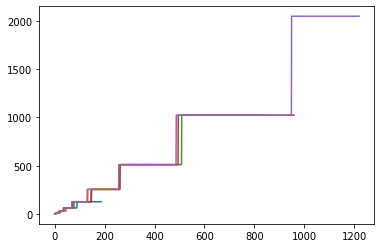

In [55]:
plt.plot(range(len(m_tiles1)), m_tiles1, label="1")
plt.plot(range(len(m_tiles2)), m_tiles2, label="2")
plt.plot(range(len(m_tiles3)), m_tiles3, label="3")
plt.plot(range(len(m_tiles4)), m_tiles4, label="4")
plt.plot(range(len(m_tiles5)), m_tiles5, label="5")
plt.show()

---

In [6]:
def tree_search_play(g, depth=5, n=1):
    """
    g is a game object, play the game using tree search until game.can_move() == false
    """
    i = 0
    scores_list = []
    while g.can_move():
        if not i % 100:
            print(i, end=" ")
#         print(g.board, "score = ", g.score)
        move, _ = tree_search_move(g, depth=depth, n=n)
#         print(move)
        _ = g.change_state(move)
        scores_list.append(g.score)
        i += 1
    return scores_list
#         print()

In [7]:
g = game(4)
scores1 = tree_search_play(g, depth=1, n=1)

[[0. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 4. 0. 0.]
 [0. 0. 0. 0.]]
0 100 

In [8]:
g = game(4)
scores2 = tree_search_play(g, depth=2, n=1)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [2. 0. 2. 0.]
 [0. 0. 0. 0.]]
0 100 200 300 400 

In [9]:
g = game(4)
scores3 = tree_search_play(g, depth=3, n=1)

[[2. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
0 100 200 300 400 

In [10]:
g = game(4)
scores4 = tree_search_play(g, depth=4, n=1)

[[0. 0. 0. 2.]
 [0. 2. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
0 100 200 300 400 500 600 700 800 

In [ ]:
g = game(4)
scores5 = tree_search_play(g, depth=5, n=1)

[[0. 0. 0. 0.]
 [0. 0. 0. 2.]
 [0. 0. 4. 0.]
 [0. 0. 0. 0.]]
0 

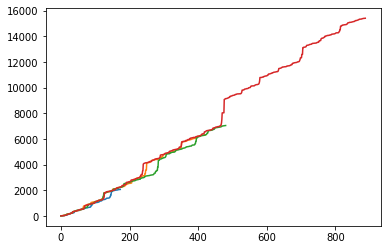

In [11]:
plt.plot(range(len(scores1)), scores1, label="1")
plt.plot(range(len(scores2)), scores2, label="2")
plt.plot(range(len(scores3)), scores3, label="3")
plt.plot(range(len(scores4)), scores4, label="4")
# plt.plot(range(len(scores5)), scores5, label="5")
plt.show()

---

In [12]:
np.random.seed(2382282283)
g = game(4)
tree_search_play(g, depth=5)
# this one won't reach 2048

[[0. 0. 0. 0.]
 [0. 0. 0. 4.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]]
0
[[0. 0. 0. 0.]
 [0. 0. 0. 4.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]] score =  0
k

1
[[0. 0. 0. 4.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]] score =  0
l

2
[[0. 0. 0. 4.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 2. 0. 2.]] score =  0
h

3
[[4. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [4. 0. 0. 4.]] score =  4.0
l

4
[[0. 0. 0. 4.]
 [0. 0. 2. 2.]
 [0. 0. 0. 0.]
 [0. 0. 0. 8.]] score =  12.0
h

5
[[4. 2. 0. 0.]
 [4. 0. 0. 0.]
 [0. 0. 0. 0.]
 [8. 0. 0. 0.]] score =  16.0
l

6
[[0. 0. 4. 2.]
 [2. 0. 0. 4.]
 [0. 0. 0. 0.]
 [0. 0. 0. 8.]] score =  16.0
k

7
[[2. 0. 4. 2.]
 [0. 0. 0. 4.]
 [2. 0. 0. 8.]
 [0. 0. 0. 0.]] score =  16.0
h

8
[[2. 4. 2. 0.]
 [4. 2. 0. 0.]
 [2. 8. 0. 0.]
 [0. 0. 0. 0.]] score =  16.0
j

9
[[0. 0. 0. 0.]
 [2. 4. 0. 0.]
 [4. 2. 0. 2.]
 [2. 8. 2. 0.]] score =  16.0
l

10
[[0. 0. 0. 0.]
 [2. 0. 2. 4.]
 [0. 0. 4. 4.]
 [0. 2. 8. 2.]] score =  20.0
k

11
[[2. 2. 2. 8.]
 [2. 0. 4. 2.]
 [0. 0. 8. 0.]
 [0. 0. 0. 0.]] scor

In [13]:
g = game(4)
tree_search_play(g, depth=5)
# this one still won't reach 2048

[[0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]]
0
[[0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]] score =  0
k

1
[[0. 0. 0. 4.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] score =  4.0
j

2
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 4.]
 [2. 0. 0. 2.]] score =  4.0
k

3
[[2. 0. 0. 4.]
 [0. 0. 0. 2.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]] score =  4.0
h

4
[[2. 4. 0. 0.]
 [2. 0. 0. 0.]
 [2. 0. 0. 2.]
 [0. 0. 0. 0.]] score =  4.0
h

5
[[2. 4. 0. 0.]
 [2. 0. 0. 0.]
 [4. 0. 0. 0.]
 [0. 2. 0. 0.]] score =  8.0
j

6
[[2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [4. 4. 0. 0.]
 [4. 2. 0. 0.]] score =  12.0
l

7
[[0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 0. 0. 8.]
 [0. 2. 4. 2.]] score =  20.0
k

8
[[2. 2. 4. 2.]
 [0. 0. 0. 8.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]] score =  20.0
h

9
[[4. 4. 2. 0.]
 [8. 0. 4. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]] score =  24.0
l

10
[[0. 0. 8. 2.]
 [0. 0. 8. 4.]
 [0. 2. 0. 2.]
 [0. 0. 0. 0.]] score =  32.0
h

11
[[8. 2. 0. 2.]
 [8. 4. 0. 0.]
 [4. 0. 0. 0.]
 [0. 0. 0. 0.]] sc

In [14]:
g = game(4)
tree_search_play(g, depth=5)
# this one will reach 2048

[[0. 2. 0. 0.]
 [4. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
0
[[0. 2. 0. 0.]
 [4. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] score =  0
j

1
[[0. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [4. 2. 0. 0.]] score =  0
j

2
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [2. 0. 0. 2.]
 [4. 2. 0. 0.]] score =  0
h

3
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [4. 0. 2. 0.]
 [4. 2. 0. 0.]] score =  4.0
l

4
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 4. 2.]
 [0. 2. 4. 2.]] score =  4.0
k

5
[[0. 2. 8. 4.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] score =  16.0
j

6
[[4. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 4.]
 [0. 2. 8. 2.]] score =  16.0
j

7
[[0. 0. 0. 0.]
 [0. 0. 4. 0.]
 [0. 0. 0. 4.]
 [4. 2. 8. 2.]] score =  16.0
l

8
[[0. 0. 0. 0.]
 [0. 0. 2. 4.]
 [0. 0. 0. 4.]
 [4. 2. 8. 2.]] score =  16.0
k

9
[[4. 2. 2. 8.]
 [0. 2. 8. 2.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] score =  24.0
j

10
[[0. 4. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 8.]
 [4. 4. 8. 2.]] score =  28.0
l

11
[[0. 0. 0. 4.]
 [0. 0. 0. 2.]
 [0. 0. 2. 8.]
 [0. 8. 8. 2.]] score

---

In [6]:
np.random.seed(2382282283)
g = game(4)
tree_search_play(g, depth=5)
# this one won't reach 2048

[[0. 0. 0. 0.]
 [0. 0. 0. 4.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]]
0
[[0. 0. 0. 0.]
 [0. 0. 0. 4.]
 [0. 0. 0. 0.]
 [0. 0. 0. 2.]] score =  0
k

1
[[0. 0. 0. 4.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [2. 0. 0. 0.]] score =  0
l

2
[[0. 0. 0. 4.]
 [0. 0. 0. 2.]
 [0. 0. 0. 0.]
 [0. 2. 0. 2.]] score =  0
h

3
[[4. 0. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 0.]
 [4. 0. 0. 4.]] score =  4.0
l

4
[[0. 0. 0. 4.]
 [0. 0. 2. 2.]
 [0. 0. 0. 0.]
 [0. 0. 0. 8.]] score =  12.0
h

5
[[4. 2. 0. 0.]
 [4. 0. 0. 0.]
 [0. 0. 0. 0.]
 [8. 0. 0. 0.]] score =  16.0
l

6
[[0. 0. 4. 2.]
 [2. 0. 0. 4.]
 [0. 0. 0. 0.]
 [0. 0. 0. 8.]] score =  16.0
k

7
[[2. 0. 4. 2.]
 [0. 0. 0. 4.]
 [2. 0. 0. 8.]
 [0. 0. 0. 0.]] score =  16.0
h

8
[[2. 4. 2. 0.]
 [4. 2. 0. 0.]
 [2. 8. 0. 0.]
 [0. 0. 0. 0.]] score =  16.0
j

9
[[0. 0. 0. 0.]
 [2. 4. 0. 0.]
 [4. 2. 0. 2.]
 [2. 8. 2. 0.]] score =  16.0
l

10
[[0. 0. 0. 0.]
 [2. 0. 2. 4.]
 [0. 0. 4. 4.]
 [0. 2. 8. 2.]] score =  20.0
k

11
[[2. 2. 2. 8.]
 [2. 0. 4. 2.]
 [0. 0. 8. 0.]
 [0. 0. 0. 0.]] scor